In [2]:
#Facebook's Prophet library already included in Colab
#!pip install fbprophet
#Install World Weather Online library and import other dependencies:
#!pip install wwo-hist
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from datetime import datetime, timedelta
import requests
from wwo_hist import retrieve_hist_data
from datetime import date
import pytz
%matplotlib inline

In [3]:
#Import our visit data from an excel file on Dropbox
df = pd.read_excel('daily-visits-incl-20-01-11.xlsx')
#Prophet only accepts these columns names:
df.columns = ['ds','y']
#Some of the timestamp day occasionally is off by a few milliseconds, not sure why, but we'll fix it by rounding:
df['ds'] = df['ds'].dt.round('15min')
#I've saved the data as hourly visits, so to convert to daily visits we group by date:
df = df.groupby([df['ds'].dt.date]).sum()
df = df.reset_index()
df = df.dropna()
df.tail()

,ds,y
2806,2020-01-07,314
2807,2020-01-08,259
2808,2020-01-09,241
2809,2020-01-10,239
2810,2020-01-11,171


In [4]:
#Import our stat days excel file, split them by RAMQ vs JGH
stat_days_df = pd.read_excel('https://www.dropbox.com/s/6kv67yhuv6f3b3h/statdays.xlsx?dl=1')
print(stat_days_df.head())
ramq_stat_days = stat_days_df['RAMQ']
ramq_stat_days = ramq_stat_days.dropna()
print(ramq_stat_days.head())
jgh_stat_days = stat_days_df['JGH']
jgh_stat_days = jgh_stat_days.dropna()
print(jgh_stat_days.head())

        RAMQ        JGH
0 2015-05-18 2015-05-18
1 2015-06-24 2015-06-24
2 2015-07-01 2015-07-01
3 2015-09-07 2015-09-07
4 2015-10-12 2015-10-12
0   2015-05-18
1   2015-06-24
2   2015-07-01
3   2015-09-07
4   2015-10-12
Name: RAMQ, dtype: datetime64[ns]
0   2015-05-18
1   2015-06-24
2   2015-07-01
3   2015-09-07
4   2015-10-12
Name: JGH, dtype: datetime64[ns]


In [5]:
#Save the stat day data in the format expected by Prophet
ramq_stat_days = pd.DataFrame({
  'holiday': 'ramq',
  'ds': ramq_stat_days.to_list(),
  'lower_window': 0,
  'upper_window': 1,
})
print(ramq_stat_days.head())
jgh_stat_days = pd.DataFrame({
  'holiday': 'jgh',
  'ds': jgh_stat_days.to_list(),
  'lower_window': 0,
  'upper_window': 1,
})
print(jgh_stat_days.head())
holidays = pd.concat((ramq_stat_days, jgh_stat_days))
print(holidays.sample(10))

  holiday         ds  lower_window  upper_window
0    ramq 2015-05-18             0             1
1    ramq 2015-06-24             0             1
2    ramq 2015-07-01             0             1
3    ramq 2015-09-07             0             1
4    ramq 2015-10-12             0             1
  holiday         ds  lower_window  upper_window
0     jgh 2015-05-18             0             1
1     jgh 2015-06-24             0             1
2     jgh 2015-07-01             0             1
3     jgh 2015-09-07             0             1
4     jgh 2015-10-12             0             1
    holiday         ds  lower_window  upper_window
108    ramq 2014-10-13             0             1
102    ramq 2014-04-18             0             1
33     ramq 2017-12-26             0             1
68     ramq 2020-09-07             0             1
39     ramq 2018-05-21             0             1
43     ramq 2018-10-08             0             1
22     ramq 2017-01-02             0             1
11  

In [6]:
#Get all Montreal Canadiens games in our time frame (2012-present) from the NHL's REST API
resp = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?teamId=8&startDate=2012-05-01&endDate=2020-05-01')
if resp.status_code != 200:
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))

games = []
for date in resp.json()['dates']:
  for g in date['games']:
    for hour in [0,1,2,3]:
          toAppend = {'dateTime':datetime.strptime(g['gameDate'], "%Y-%m-%dT%H:%M:%SZ")-timedelta(hours=5-hour),'homeTeam':g['teams']['home']['team']['name'], 'awayTeam':g['teams']['away']['team']['name']}
          toAppend['awayScore'] = g['teams']['away']['score']
          toAppend['homeScore'] = g['teams']['home']['score']
          games.append(toAppend)
hockey_df = pd.DataFrame(games)
hockey_df['dateTime'] = hockey_df['dateTime'].dt.date
print(hockey_df.sample(5))

#Separate the games by Home or Away
home_hockey_df = hockey_df[hockey_df['homeTeam'].isin(['Montréal Canadiens','MontrÃ©al Canadiens'])]
print(home_hockey_df.sample(5))

away_hockey_df = hockey_df[hockey_df['awayTeam'].isin(['Montréal Canadiens','MontrÃ©al Canadiens'])]
print(away_hockey_df.sample(5))

#Format them as Prophet expects
home_hockey = pd.DataFrame({
  'holiday': 'homeHockey',
  'ds': pd.to_datetime(home_hockey_df['dateTime']),
  'lower_window': 0,
  'upper_window': 1,
})

away_hockey = pd.DataFrame({
  'holiday': 'awayHockey',
  'ds': pd.to_datetime(away_hockey_df['dateTime']),
  'lower_window': 0,
  'upper_window': 1,
})

#Add the hockey games to our stat day data
holidays = pd.concat((home_hockey, away_hockey, ramq_stat_days, jgh_stat_days))
print(holidays.sample(10))

        dateTime             homeTeam              awayTeam  awayScore  \
850   2015-01-29     New York Rangers    Montréal Canadiens          1   
2716  2020-01-18   Montréal Canadiens  Vegas Golden Knights          0   
555   2014-04-05   Montréal Canadiens     Detroit Red Wings          3   
221   2013-09-20  Carolina Hurricanes    Montréal Canadiens          6   
2451  2019-03-16   Montréal Canadiens    Chicago Blackhawks          2   

      homeScore  
850           0  
2716          0  
555           5  
221           0  
2451          0  
        dateTime            homeTeam             awayTeam  awayScore  \
2610  2019-11-23  Montréal Canadiens     New York Rangers          6   
2490  2019-04-06  Montréal Canadiens  Toronto Maple Leafs          5   
1059  2015-09-28  Montréal Canadiens  Pittsburgh Penguins          1   
1040  2015-09-22  Montréal Canadiens  Toronto Maple Leafs          2   
2257  2018-11-24  Montréal Canadiens        Boston Bruins          3   

      homeScor

In [7]:
#Some final formatting our our data to be able to merge it with the weather data
df.ds = pd.to_datetime(df.ds)

In [8]:
#Instantiate our model with our stat day and hockey variables saved in the 'holidays' dataframe
m = Prophet(holidays=holidays)
#Add Prophet's built-in holidays for Canada
m.add_country_holidays(country_name='CA')
#Fit our model to our data
m.fit(df)
#Fit our model to data from before 2019
#m.fit(final_df[final_df.ds<'2019-01-01'])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/envs/prophet/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [9]:
future = m.make_future_dataframe(365,'D')
forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds        yhat  yhat_lower  yhat_upper
3171 2021-01-06  274.689329  253.517697  297.098483
3172 2021-01-07  272.072047  250.669512  295.990370
3173 2021-01-08  276.805277  255.640464  299.840613
3174 2021-01-09  238.379145  217.885793  258.089685
3175 2021-01-10  238.153101  216.442110  261.287525


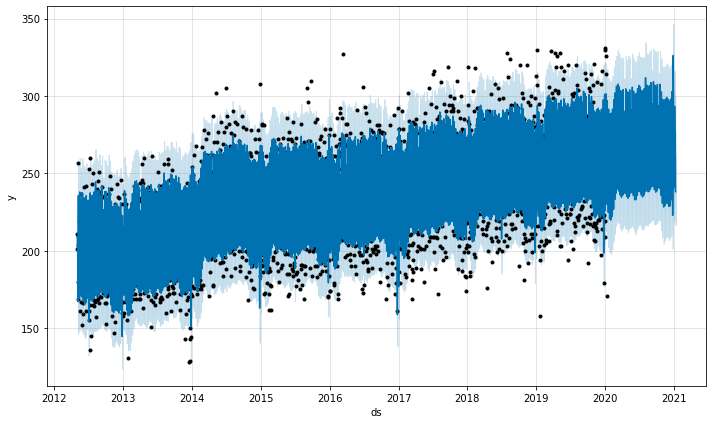

In [10]:
fig1 = m.plot(forecast)

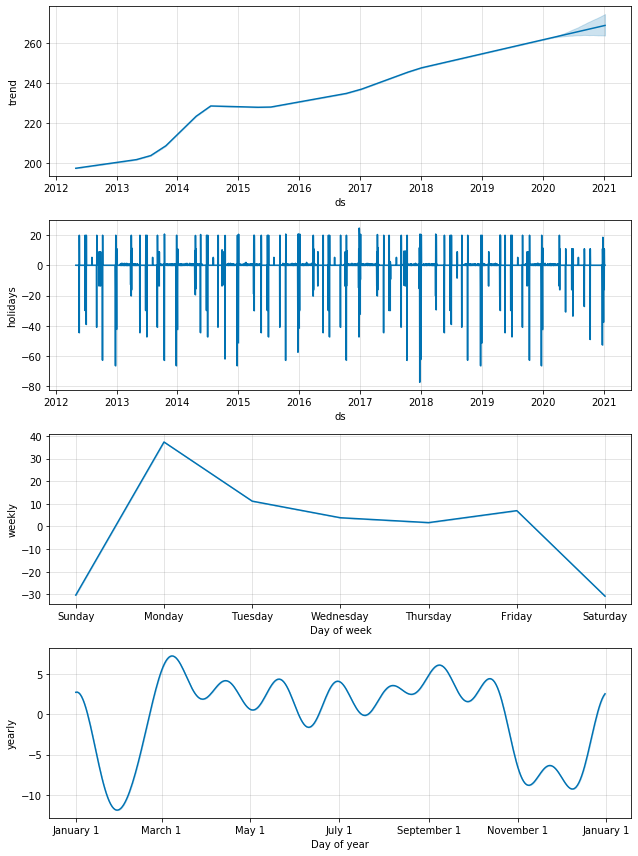

In [11]:
fig2 = m.plot_components(forecast)

In [12]:
import pickle
pkl_path = "longterm-20-01-12.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m, f)

In [13]:
# read the Prophet model object
with open(pkl_path, 'rb') as f:
    m = pickle.load(f)

In [14]:
m